# Document Text Recognition and Classification using LayoutMv3

**Dataset** from [**Hugging Face**](https://huggingface.co/datasets/nielsr/funsd-layoutlmv3)

## Environment setup

First, we install Transformers, along with Datasets and Seqeval (the latter useful for estimating metrics like F1 in sequence labeling tasks).

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 93.6 MB/s eta 0:00:00


In [ ]:
!pip install -q datasets seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 8.2 MB/s eta 0:00:00


## Loading data

In [ ]:
from datasets import load_dataset 

# this dataset uses the new Image feature :)
dataset = load_dataset("nielsr/funsd-layoutlmv3")

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset funsd-layoutlmv3 downloaded and prepared to /root/.cache/huggingface/datasets/nielsr___funsd-layoutlmv3/funsd/1.0.0/0e3f4efdfd59aa1c3b4952c517894f7b1fc4d75c12ef01bcc8626a69e41c1bb9. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

As we can see, the dataset consists of 2 sections ("train" and "test") and each example contains a list of words ("tokens") with corresponding boxes ("bboxes") and the words are tagged ("ner_tags"). Each example also includes a source image ("image").

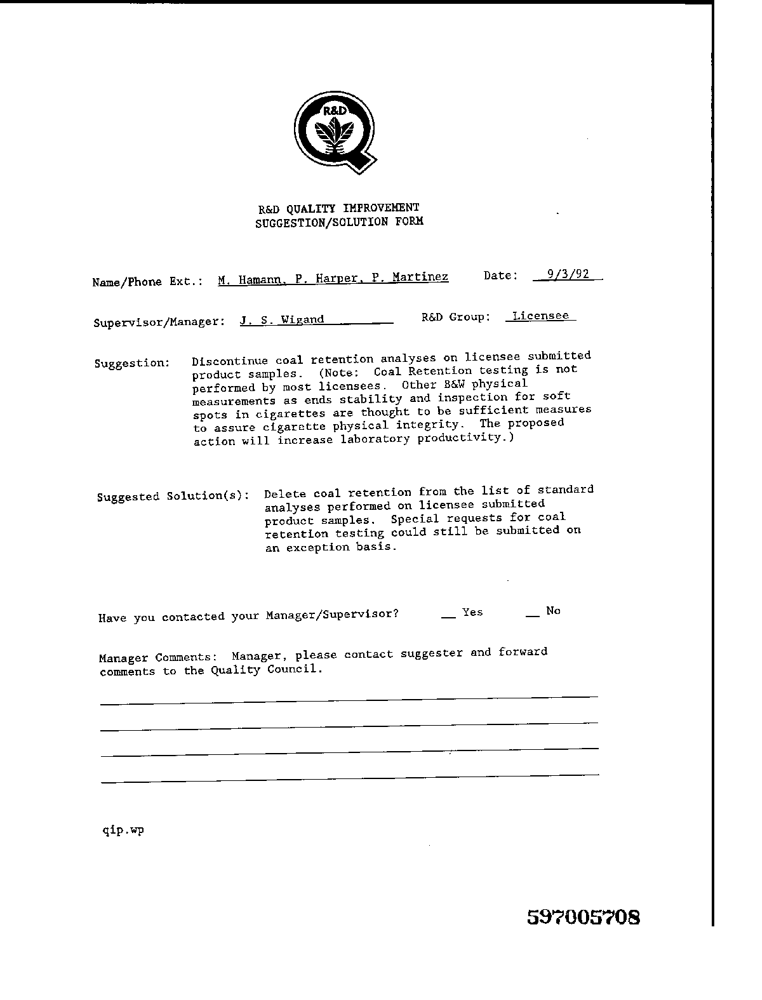

In [ ]:
example = dataset["train"][0]
example["image"]

## Dataset preparation

Next, we prepare a dataset for the model. This can be done very easily with `LayoutLMv3Processor`, which internally combines `LayoutLMv3FeatureExtractor` (for image modality) and `LayoutLMv3Tokenizer` (for text modality) into one.

Basically, the processor does the following internally:
* feature extractor is used to resize + normalize each document image to `pixel_values`
* tokenizer is used to convert NER words, blocks, and tags into token-level `input_ids`, `attention_mask`, and `label`.

The processor simply returns a dictionary containing all of these keys.

In [ ]:
from transformers import AutoProcessor

# we'll use the Auto API here - it will load LayoutLMv3Processor behind the scenes,
# based on the checkpoint we provide from the hub
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

Downloading:   0%|          | 0.00/275 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/856 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

First we will create id2label and label2id mappings useful for inference. Note that LayoutLMv3ForTokenClassification (the model we'll use later) will simply output an integer index for a specific class (for each token), so we still need to map it to the actual class name.

In [ ]:
from datasets.features import ClassLabel

features = dataset["train"].features
column_names = dataset["train"].column_names
image_column_name = "image"
text_column_name = "tokens"
boxes_column_name = "bboxes"
label_column_name = "ner_tags"

# In the event the labels are not a `Sequence[ClassLabel]`, we will need to go through the dataset to get the
# unique labels.
def get_label_list(labels):
    unique_labels = set()
    for label in labels:
        unique_labels = unique_labels | set(label)
    label_list = list(unique_labels)
    label_list.sort()
    return label_list

if isinstance(features[label_column_name].feature, ClassLabel):
    label_list = features[label_column_name].feature.names
    # No need to convert the labels since they are already ints.
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
else:
    label_list = get_label_list(dataset["train"][label_column_name])
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
num_labels = len(label_list)

In [ ]:
print(label_list)

['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER']


In [ ]:
print(id2label)

{0: 'O', 1: 'B-HEADER', 2: 'I-HEADER', 3: 'B-QUESTION', 4: 'I-QUESTION', 5: 'B-ANSWER', 6: 'I-ANSWER'}


Next, we define a function that we can apply to the entire data set.

In [ ]:
def prepare_examples(examples):
  images = examples[image_column_name]
  words = examples[text_column_name]
  boxes = examples[boxes_column_name]
  word_labels = examples[label_column_name]

  encoding = processor(images, words, boxes=boxes, word_labels=word_labels,
                       truncation=True, padding="max_length")

  return encoding

In [ ]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D

# we need to define custom features for `set_format` (used later on) to work properly
features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(feature=Value(dtype='int64')),
})

train_dataset = dataset["train"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)
eval_dataset = dataset["test"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
train_dataset

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 149
})

In [ ]:
example = train_dataset[0]
processor.tokenizer.decode(example["input_ids"])

'<s> R&D : Suggestion: Date: Licensee Yes No 597005708 R&D QUALITY IMPROVEMENT SUGGESTION/ SOLUTION FORM Name / Phone Ext. : M. Hamann P. Harper, P. Martinez 9/ 3/ 92 R&D Group: J. S. Wigand Supervisor / Manager Discontinue coal retention analyses on licensee submitted product samples (Note : Coal Retention testing is not performed by most licensees. Other B&W physical measurements as ends stability and inspection for soft spots in ciparettes are thought to be sufficient measures to assure cigarette physical integrity. The proposed action will increase laboratory productivity. ) Suggested Solutions (s) : Delete coal retention from the list of standard analyses performed on licensee submitted product samples. Special requests for coal retention testing could still be submitted on an exception basis. Have you contacted your Manager/ Supervisor? Manager Comments: Manager, please contact suggester and forward comments to the Quality Council. qip. wp</s><pad><pad><pad><pad><pad><pad><pad><p

Next, we set the PyTorch format.

In [ ]:
train_dataset.set_format("torch")

Let's check that everything is created correctly:

In [ ]:
import torch

example = train_dataset[0]
for k,v in example.items():
    print(k,v.shape)

pixel_values torch.Size([3, 224, 224])
input_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])


In [ ]:
eval_dataset

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 50
})

In [ ]:
processor.tokenizer.decode(eval_dataset[0]["input_ids"])

"<s> TO: DATE: 3 Fax: NOTE: 82092117 614 -466 -5087 Dec 10 '98 17 :46 P. 01 ATT. GEN. ADMIN. OFFICE Attorney General Betty D. Montgomery CONFIDENTIAL FACSIMILE TRANSMISSION COVER SHEET (614) 466- 5087 FAX NO. George Baroody (336) 335- 7392 FAX NUMBER: PHONE NUMBER: (336) 335- 7363 NUMBER OF PAGES INCLUDING COVER SHEET: June Flynn for Eric Brown/ (614) 466- 8980 SENDER /PHONE NUMBER: SPECIAL INSTRUCTIONS: IF YOU DO NOT RECEIVE ANY OF THE PAGES PROPERLY, PLEASE CONTACT SENDER AS SOON AS POSSIBLE THIS MESSAGE IS INTENDED ONLY FOR THE USE OF THE INDIVIDUAL OR ENTITY TO WHOM IT IS ADDRESSED AND MAY CONTAIN INFORMATION THAT IS PRIVILEGED. CONFIDENTIAL, AND EXEMPT FROM DISCLOSURE UNDER APPLICABLE LAW. If the reader of this message is not the intended recipient of the employee or agent responsible for delivering the message to the intended recipient, you are hereby notified that any dissemination, distribution, copying, or conveying of this communication in any manner is strictly prohibited. I

In [ ]:
for id, label in zip(train_dataset[0]["input_ids"], train_dataset[0]["labels"]):
  print(processor.tokenizer.decode([id]), label.item())

<s> -100
 R 0
& -100
D -100
 : 3
 Suggest 3
ion -100
: -100
 Date 3
: -100
 License 5
e -100
 Yes 3
 No 3
 5 0
97 -100
005 -100
708 -100
 R 1
& -100
D -100
 QU 2
AL -100
ITY -100
 IM 2
PROV -100
EMENT -100
 S 2
UG -100
G -100
EST -100
ION -100
/ -100
 SOL 2
UTION -100
 FORM 2
 Name 3
 / 4
 Phone 4
 Ext 4
. -100
 : 4
 M 5
. -100
 Ham 6
ann -100
 P 6
. -100
 Harper 6
, -100
 P 6
. -100
 Martinez 6
 9 5
/ -100
 3 6
/ -100
 92 6
 R 3
& -100
D -100
 Group 4
: -100
 J 5
. -100
 S 6
. -100
 W 6
ig -100
and -100
 Supervisor 3
 / 4
 Manager 4
 Disc 5
ont -100
in -100
ue -100
 coal 6
 retention 6
 analyses 6
 on 6
 licensee 6
 submitted 6
 product 6
 samples 6
 ( 6
Note -100
 : 6
 Coal 6
 Ret 6
ention -100
 testing 6
 is 6
 not 6
 performed 6
 by 6
 most 6
 license 6
es -100
. -100
 Other 6
 B 6
& -100
W -100
 physical 6
 measurements 6
 as 6
 ends 6
 stability 6
 and 6
 inspection 6
 for 6
 soft 6
 spots 6
 in 6
 c 6
ip -100
arettes -100
 are 6
 thought 6
 to 6
 be 6
 sufficient 6
 measures 6
 

## Determination of indicators

Next, we define the compute_metrics function, which is used by the Trainer to... compute metrics.

This function should take a named tuple as input and return a dictionary as output as specified in the docs.

In [ ]:
from datasets import load_metric

metric = load_metric("seqeval")

<ipython-input-18-edef154daec7>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")


In [ ]:
import numpy as np

return_entity_level_metrics = False

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

## Model definition

Next, we define a model: it is a Transformer encoder with pre-trained weights and randomly initialized headers on top for token classification.

In [ ]:
from transformers import LayoutLMv3ForTokenClassification

model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base",
                                                         id2label=id2label,
                                                         label2id=label2id)

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Defining TrainingArguments + Trainer

Next, we define TrainingArguments, which define all training-related hyperparameters.

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test",
                                  max_steps=1000,
                                  per_device_train_batch_size=2,
                                  per_device_eval_batch_size=2,
                                  learning_rate=1e-5,
                                  evaluation_strategy="steps",
                                  eval_steps=100,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1")

We can now instantiate the trainer with the model and arguments defined above. We also provide our datasets as well as a "default data mapping system" that will group examples using torch.stack. We also provide our compute_metrics function defined above.

In [ ]:
from transformers.data.data_collator import default_data_collator

# Initialize our Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

max_steps is given, it will override any value given in num_train_epochs


## Model training

In [ ]:
trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 149
  Num Epochs = 14
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 1
  Total optimization steps = 1000
  Number of trainable parameters = 125332359
/usr/local/lib/python3.8/dist-packages/transformers/modeling_utils.py:810: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
100,No log,0.650613,0.761712,0.840040,0.798961,0.791275
200,No log,0.511289,0.809524,0.869846,0.838602,0.832521
300,No log,0.490419,0.844538,0.898659,0.870758,0.843575
400,No log,0.518611,0.870735,0.900149,0.885198,0.843575
500,0.533600,0.577580,0.867470,0.894188,0.880626,0.838940
600,0.533600,0.584557,0.863767,0.897665,0.880390,0.836325
700,0.533600,0.602179,0.886419,0.911078,0.898579,0.854511
800,0.533600,0.599804,0.879847,0.913065,0.896148,0.845358
900,0.533600,0.591190,0.894507,0.914059,0.904177,0.860573
1000,0.120200,0.602879,0.902547,0.915549,0.909001,0.858196


***** Running Evaluation *****
  Num examples = 50
  Batch size = 2
***** Running Evaluation *****
  Num examples = 50
  Batch size = 2
***** Running Evaluation *****
  Num examples = 50
  Batch size = 2
***** Running Evaluation *****
  Num examples = 50
  Batch size = 2
***** Running Evaluation *****
  Num examples = 50
  Batch size = 2
Saving model checkpoint to test/checkpoint-500
Configuration saved in test/checkpoint-500/config.json
Model weights saved in test/checkpoint-500/pytorch_model.bin
Image processor saved in test/checkpoint-500/preprocessor_config.json
tokenizer config file saved in test/checkpoint-500/tokenizer_config.json
Special tokens file saved in test/checkpoint-500/special_tokens_map.json
/usr/local/lib/python3.8/dist-packages/transformers/modeling_utils.py:810: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
***** Running Evaluation *****
  Num examples = 50
  Batch size = 2
***** Running Evaluation **

TrainOutput(global_step=1000, training_loss=0.32688541793823245, metrics={'train_runtime': 524.573, 'train_samples_per_second': 3.813, 'train_steps_per_second': 1.906, 'total_flos': 523783817001984.0, 'train_loss': 0.32688541793823245, 'epoch': 13.33})

In [ ]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 50
  Batch size = 2
/usr/local/lib/python3.8/dist-packages/transformers/modeling_utils.py:810: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'eval_loss': 0.6028786301612854,
 'eval_precision': 0.9025465230166504,
 'eval_recall': 0.9155489319423745,
 'eval_f1': 0.9090012330456226,
 'eval_accuracy': 0.8581956495899203,
 'eval_runtime': 4.943,
 'eval_samples_per_second': 10.115,
 'eval_steps_per_second': 5.058,
 'epoch': 13.33}

## Conclusions

Let's download the model that nielsr worked on

In [ ]:
from transformers import AutoModelForTokenClassification
model = AutoModelForTokenClassification.from_pretrained("nielsr/layoutlmv3-finetuned-funsd")

Downloading:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--nielsr--layoutlmv3-finetuned-funsd/snapshots/b447ff868f5c7e3fa154fbe12fbabb6ce9421187/config.json
Model config LayoutLMv3Config {
  "_name_or_path": "nielsr/layoutlmv3-finetuned-funsd",
  "architectures": [
    "LayoutLMv3ForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "coordinate_size": 128,
  "eos_token_id": 2,
  "finetuning_task": "ner",
  "has_relative_attention_bias": true,
  "has_spatial_attention_bias": true,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-HEADER",
    "2": "I-HEADER",
    "3": "B-QUESTION",
    "4": "I-QUESTION",
    "5": "B-ANSWER",
    "6": "I-ANSWER"
  },
  "initializer_range": 0.02,
  "input_size": 224,
  "intermediate_size": 3072,
  "label2id": {
    "B-ANSWER": 5,
    "B-HEADER": 1,
    "B-QUESTION": 3,
    "I-ANSWER": 6,
    

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--nielsr--layoutlmv3-finetuned-funsd/snapshots/b447ff868f5c7e3fa154fbe12fbabb6ce9421187/pytorch_model.bin
All model checkpoint weights were used when initializing LayoutLMv3ForTokenClassification.

All the weights of LayoutLMv3ForTokenClassification were initialized from the model checkpoint at nielsr/layoutlmv3-finetuned-funsd.
If your task is similar to the task the model of the checkpoint was trained on, you can already use LayoutLMv3ForTokenClassification for predictions without further training.


Let's take an example of a training data set to show the inference.

In [ ]:
example = dataset["test"][3]
print(example.keys())

dict_keys(['id', 'tokens', 'bboxes', 'ner_tags', 'image'])


First, we prepare it for the model using the processor.

In [ ]:
image = example["image"]
words = example["tokens"]
boxes = example["bboxes"]
word_labels = example["ner_tags"]

encoding = processor(image, words, boxes=boxes, word_labels=word_labels, return_tensors="pt")
for k,v in encoding.items():
  print(k,v.shape)

input_ids torch.Size([1, 321])
attention_mask torch.Size([1, 321])
bbox torch.Size([1, 321, 4])
labels torch.Size([1, 321])
pixel_values torch.Size([1, 3, 224, 224])


Next, we make a forward transfer. We use torch.no_grad() because we don't need gradient calculations..

In [ ]:
with torch.no_grad():
  outputs = model(**encoding)

The model outputs logits of the form (batch_size, seq_len, num_labels).

In [ ]:
logits = outputs.logits
logits.shape

torch.Size([1, 321, 7])

We take the highest score for each token using argmax. This serves as the predicted label for each marker.

In [ ]:
predictions = logits.argmax(-1).squeeze().tolist()
print(predictions)

[6, 5, 3, 4, 3, 3, 4, 3, 4, 3, 4, 5, 5, 3, 4, 3, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 3, 4, 4, 3, 4, 4, 4, 4, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 5, 6, 6, 6, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 1, 4, 4, 4, 4, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 4, 4, 4, 4, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 4, 4, 4, 4, 4, 5, 6, 6, 6, 6, 6, 6, 3, 4, 4, 4, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 6, 6, 6, 6, 6]


Let's compare this to the ground truth: Note that many labels have a value of -100 because we only label the first subword token of each word.

NOTE: during "real inference" you don't have access to the labels, see the last section of this notebook for how you can use `offset_mapping` in that case.

In [ ]:
labels = encoding.labels.squeeze().tolist()
print(labels)

[-100, 5, 3, -100, 3, 3, -100, 3, -100, 3, -100, 5, 0, 3, -100, 3, -100, -100, -100, 0, -100, -100, -100, 0, -100, -100, -100, -100, 0, -100, 0, 0, -100, 0, 0, -100, 0, -100, -100, -100, 0, -100, 0, -100, -100, 0, -100, -100, 0, -100, 1, 2, 2, 2, 3, 4, -100, 3, 4, -100, 4, -100, 5, 6, 6, -100, 6, -100, 6, 6, 6, -100, 6, 6, 6, -100, 6, -100, 6, -100, 5, -100, 6, -100, 6, -100, 5, -100, 6, -100, 6, -100, 5, 6, -100, 6, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 1, -100, -100, 2, -100, 3, 4, 4, 4, 4, 4, 4, -100, -100, 4, 3, -100, -100, 4, -100, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, -100, -100, 5, -100, 6, 6, 6, -100, 6, 6, 6, 6, 6, 6, 6, -100, -100, 6, -100, 6, 6, 6, 6, 6, 6, 6, -100, 6, 6, -100, 6, -100, 6, -100, 6, 6, 6, 6, -100, 6, 6, 6, 6, 6, 6, 6, 6, 6, -100, 5, 6, -100, 6, -100, 6, -100, -100, 6, 6, 6, 6, -100, 0, 0, -100, 0, 0, 0, 0, 0, 0, 0, 0, -100, -100, 0, 0, -100, 0, -100, 0, -100, -100, 0, -100, 1, 2, -100, 2, -100, -100, 3, 4, 4, 4, 4, 4, 4, 3, 4, 4, -100, 5, 6, 6, 6, 6, 6, 6, -100, 

So let's compare predictions and labels only at positions where the label is not -100. We also want bounding boxes of these (non-normalized):

In [ ]:
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

token_boxes = encoding.bbox.squeeze().tolist()
width, height = image.size

true_predictions = [model.config.id2label[pred] for pred, label in zip(predictions, labels) if label != - 100]
true_labels = [model.config.id2label[label] for prediction, label in zip(predictions, labels) if label != -100]
true_boxes = [unnormalize_box(box, width, height) for box, label in zip(token_boxes, labels) if label != -100]

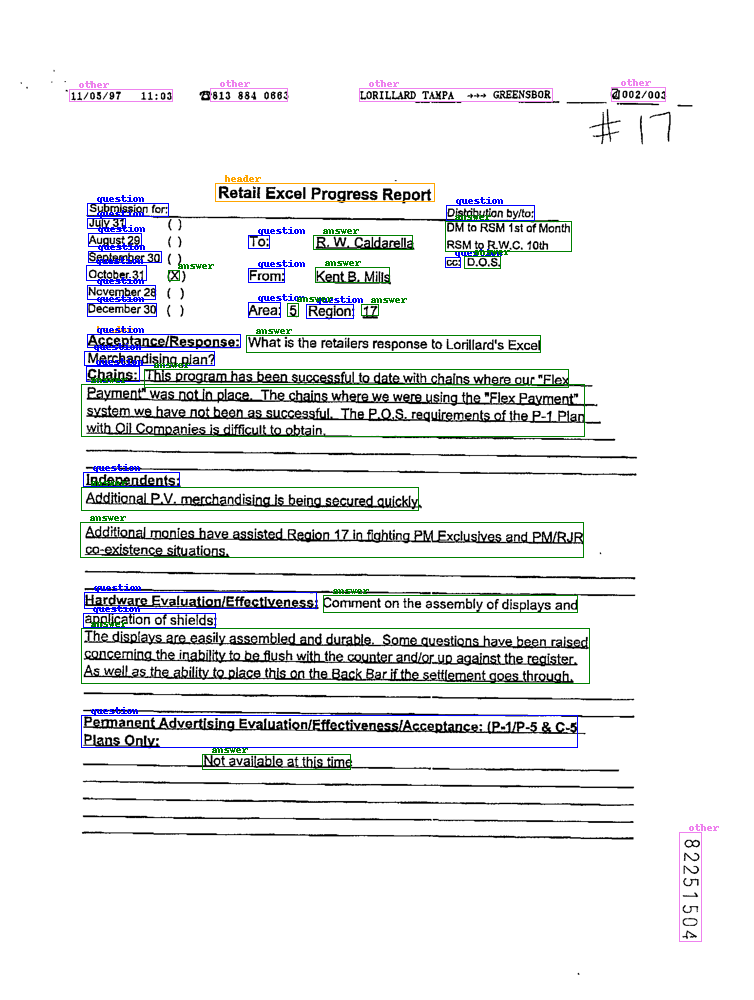

In [ ]:
from PIL import ImageDraw, ImageFont

draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

def iob_to_label(label):
    label = label[2:]
    if not label:
      return 'other'
    return label

label2color = {'question':'blue', 'answer':'green', 'header':'orange', 'other':'violet'}

for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = iob_to_label(prediction).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)

image

Contrast this with the ground truth:

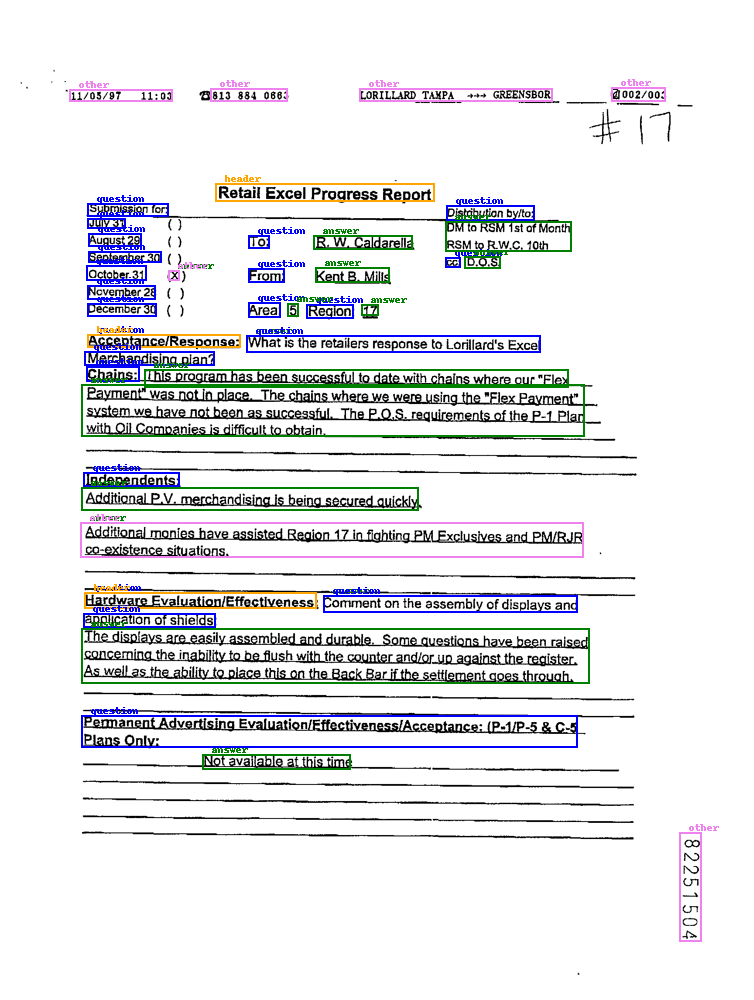

In [ ]:
image = example["image"]
image = image.convert("RGB")

draw = ImageDraw.Draw(image)

for word, box, label in zip(example['tokens'], example['bboxes'], example['ner_tags']):
  actual_label = iob_to_label(id2label[label]).lower()
  box = unnormalize_box(box, width, height)
  draw.rectangle(box, outline=label2color[actual_label], width=2)
  draw.text((box[0] + 10, box[1] - 10), actual_label, fill=label2color[actual_label], font=font)

image